In [ ]:
!pip install allensdk==2.9.0

In [1]:
import os
import shutil
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, plot_confusion_matrix, confusion_matrix, precision_recall_fscore_support
from sklearn.model_selection import cross_val_score, cross_validate, GridSearchCV, RandomizedSearchCV

from allensdk.brain_observatory.ecephys.ecephys_session import EcephysSession
from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache
from allensdk.brain_observatory.ecephys.ecephys_project_api.utilities import build_and_execute
from allensdk.brain_observatory.ecephys.ecephys_project_api.rma_engine import RmaEngine
from allensdk.brain_observatory.ecephys.visualization import plot_mean_waveforms, plot_spike_counts, raster_plot

##Introduction to Machine Learning

In [3]:
penguins = sns.load_dataset('penguins').dropna()
penguins.head()

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181.0,3750.0,Male
1,Adelie,Torgersen,39.5,17.4,186.0,3800.0,Female
2,Adelie,Torgersen,40.3,18.0,195.0,3250.0,Female
4,Adelie,Torgersen,36.7,19.3,193.0,3450.0,Female
5,Adelie,Torgersen,39.3,20.6,190.0,3650.0,Male


###Targets for the Model
We would like to create a model that is able to predict the specie of the penguin based on certain features. For that we should first convert the species names to numerical labels.

In [75]:
le = LabelEncoder()
y = le.fit_transform(penguins.species)
print(f'Label Classes: {le.classes_}')

Label Classes: ['Adelie' 'Chinstrap' 'Gentoo']


###SVM
[Introduction to SVM](https://monkeylearn.com/blog/introduction-to-support-vector-machines-svm/#:~:text=A%20support%20vector%20machine%20(SVM,able%20to%20categorize%20new%20text.)

In [85]:
def plot_svm(clf, X, y, ax, h=.02):
  """Helper function for plotting the separation planes and support vectors,
     found by the SVM model"""
  x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
  y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
  xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
  Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
  # Put the result into a color plot
  Z = Z.reshape(xx.shape)
  ax.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)
  # Plot also the training points
  ax.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm)
  ax.set_xlim(xx.min(), xx.max())
  ax.set_ylim(yy.min(), yy.max())
  ax.axis('off')


def evaluate_model(clf, X, y):
  fig, axes = plt.subplots(1,2,figsize=(13,5))
  plot_confusion_matrix(clf, X, y, ax=axes[0]);
  plot_svm(clf, X, y, ax=axes[1], h=0.1);

  y_pred = clf.predict(X)
  print(classification_report(y, y_pred))

###Case 1 - Simply Separable Data

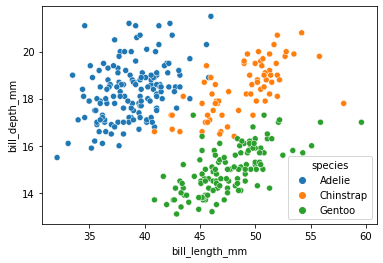

In [73]:
sns.scatterplot(x='bill_length_mm', y='bill_depth_mm', data=penguins, hue='species');

In [83]:
X = penguins[['bill_length_mm', 'bill_depth_mm']].to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)

              precision    recall  f1-score   support

           0       0.94      1.00      0.97        31
           1       1.00      0.73      0.84        11
           2       0.96      1.00      0.98        25

    accuracy                           0.96        67
   macro avg       0.97      0.91      0.93        67
weighted avg       0.96      0.96      0.95        67



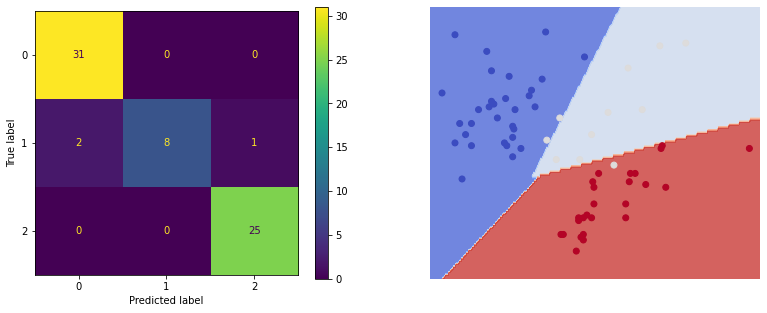

In [86]:
clf = SVC(kernel='linear')
clf.fit(X_train, y_train)
evaluate_model(clf, X_test, y_test)

###Case 2 - Non-Linear Separation

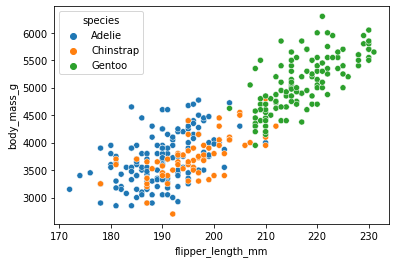

In [74]:
sns.scatterplot(x='flipper_length_mm', y='body_mass_g', data=penguins, hue='species');

In [88]:
X = penguins[['flipper_length_mm', 'body_mass_g']].to_numpy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)

              precision    recall  f1-score   support

           0       0.71      0.93      0.81        29
           1       0.67      0.27      0.38        15
           2       1.00      1.00      1.00        23

    accuracy                           0.81        67
   macro avg       0.79      0.73      0.73        67
weighted avg       0.80      0.81      0.78        67



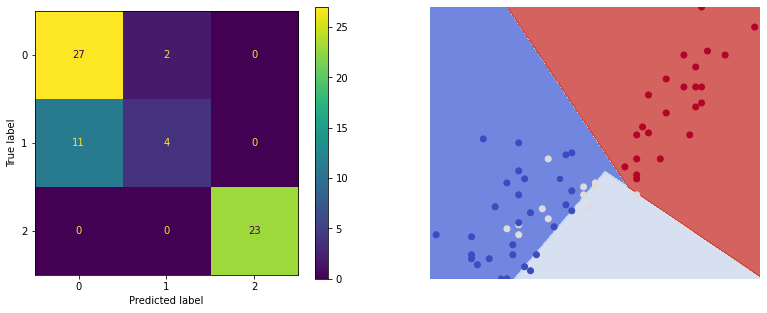

In [89]:
clf = SVC(kernel='linear')
clf.fit(X_train, y_train)
evaluate_model(clf, X_test, y_test)

###Precision vs Recall

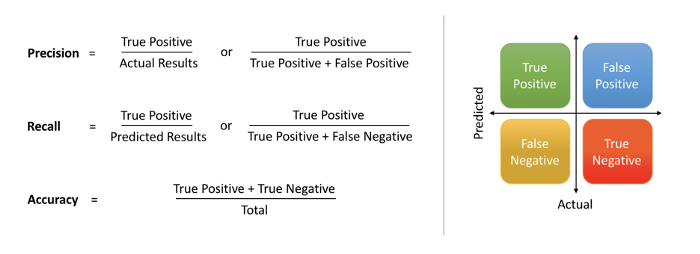

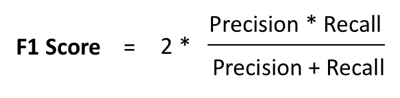

###cross-validation

              precision    recall  f1-score   support

           0       0.71      0.93      0.81        29
           1       0.67      0.27      0.38        15
           2       1.00      1.00      1.00        23

    accuracy                           0.81        67
   macro avg       0.79      0.73      0.73        67
weighted avg       0.80      0.81      0.78        67



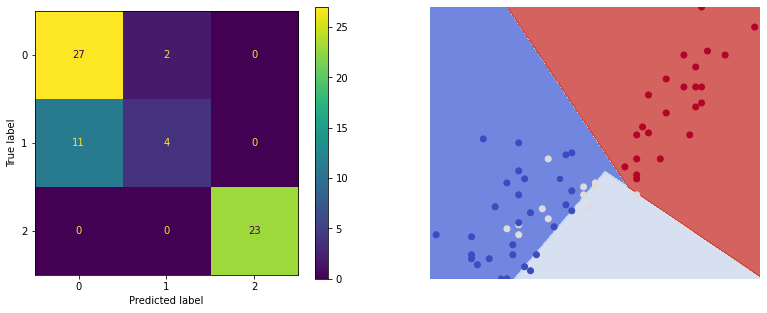

In [90]:
model = SVC(kernel='linear')
scores = cross_validate(model, X_train, y_train, 
                        scoring='f1_weighted', cv=5, return_estimator=True)
best_model = scores['estimator'][scores['test_score'].argmax()]
evaluate_model(clf, X_test, y_test)

###Hyper-parmater Tuning

####Accuracy Scoring

Best Parameters: {'gamma': 1e-05, 'C': 1000}

              precision    recall  f1-score   support

           0       0.79      0.90      0.84        29
           1       0.73      0.53      0.62        15
           2       1.00      1.00      1.00        23

    accuracy                           0.85        67
   macro avg       0.84      0.81      0.82        67
weighted avg       0.85      0.85      0.84        67



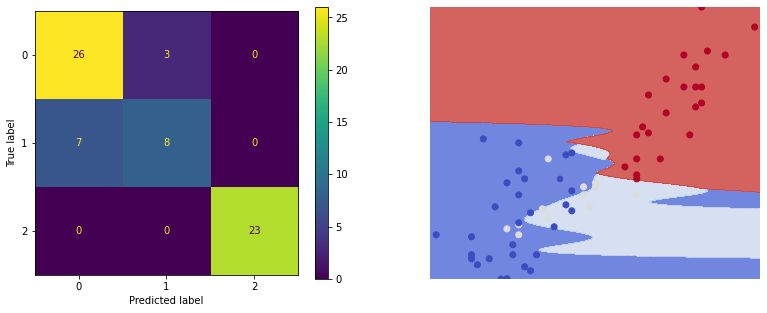

In [91]:
clf = SVC(kernel='rbf', probability=True, cache_size=600)

gamma_range = [1e-7, 1e-6, 1e-5, 1e-4, 0.001, 0.01, 0.1, 1, 10]
c_range = [0.001, 0.01, 0.1, 1, 10, 100, 1000, 1e4, 1e5]
param_grid = dict(gamma=gamma_range, C=c_range)

grid = RandomizedSearchCV(clf, param_grid, cv=5, scoring="accuracy", n_jobs=-1)
grid.fit(X_train, y_train)
print(f'Best Parameters: {grid.best_params_}\n')
evaluate_model(grid.best_estimator_, X_test, y_test)

####Precision Scoring

Best Parameters: {'gamma': 1e-07, 'C': 100000.0}

              precision    recall  f1-score   support

           0       0.76      0.97      0.85        29
           1       0.86      0.40      0.55        15
           2       1.00      1.00      1.00        23

    accuracy                           0.85        67
   macro avg       0.87      0.79      0.80        67
weighted avg       0.86      0.85      0.83        67



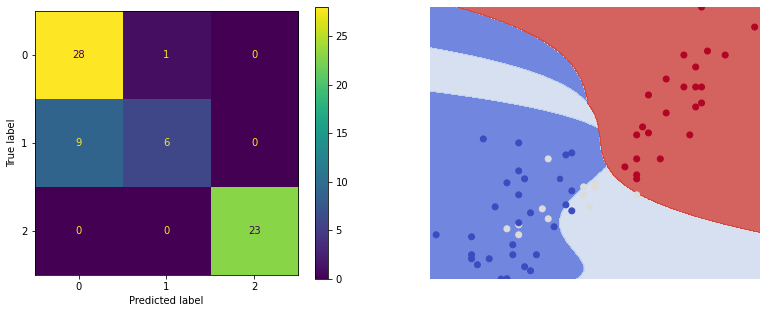

In [99]:
clf = SVC(kernel='rbf', probability=True, cache_size=600)

gamma_range = [1e-7, 1e-6, 1e-5, 1e-4, 0.001, 0.01, 0.1, 1, 10]
c_range = [0.001, 0.01, 0.1, 1, 10, 100, 1000, 1e4, 1e5]
param_grid = dict(gamma=gamma_range, C=c_range)

grid = RandomizedSearchCV(clf, param_grid, cv=5, scoring="precision_macro", n_jobs=-1)
grid.fit(X_train, y_train)
print(f'Best Parameters: {grid.best_params_}\n')
evaluate_model(grid.best_estimator_, X_test, y_test)

####Recall Scoring

Best Parameters: {'gamma': 0.001, 'C': 1000}

              precision    recall  f1-score   support

           0       0.73      0.83      0.77        29
           1       0.60      0.60      0.60        15
           2       0.95      0.78      0.86        23

    accuracy                           0.76        67
   macro avg       0.76      0.74      0.74        67
weighted avg       0.77      0.76      0.76        67



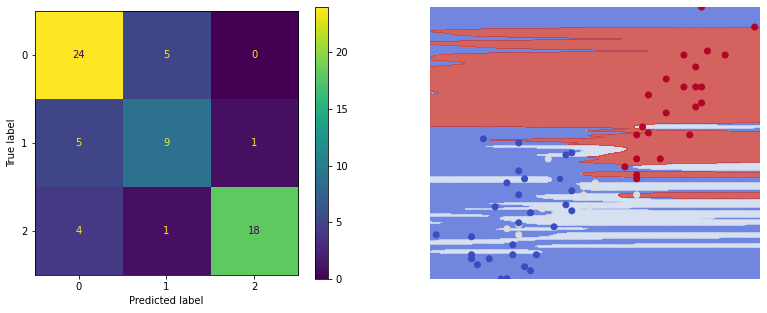

In [100]:
clf = SVC(kernel='rbf', probability=True, cache_size=600)

gamma_range = [1e-7, 1e-6, 1e-5, 1e-4, 0.001, 0.01, 0.1, 1, 10]
c_range = [0.001, 0.01, 0.1, 1, 10, 100, 1000, 1e4, 1e5]
param_grid = dict(gamma=gamma_range, C=c_range)

grid = RandomizedSearchCV(clf, param_grid, cv=5, scoring="recall_macro", n_jobs=-1)
grid.fit(X_train, y_train)
print(f'Best Parameters: {grid.best_params_}\n')
evaluate_model(grid.best_estimator_, X_test, y_test)

##V1 Encoding Classification

In [2]:
data_directory = '/content/drive/MyDrive/ecephys_cache/' # must be updated to a valid directory in your filesystem
manifest_path = os.path.join(data_directory, "manifest.json")
cache = EcephysProjectCache.from_warehouse(manifest=manifest_path)

In [3]:
session_id = 750749662
session = cache.get_session_data(session_id)

Getting all spikes related to V1 neurons during the natural scenes presentations.

In [ ]:
scene_presentations = session.get_stimulus_table("natural_scenes")
# get all units from V1
v1_units = session.units[session.units.ecephys_structure_acronym.str.startswith('VI')]

spikes = session.presentationwise_spike_times(
    stimulus_presentation_ids=scene_presentations.index.values,
    unit_ids=v1_units.index.values[:]
)

Using units as features and presentations as observations.

In [5]:
spikes["count"] = np.zeros(spikes.shape[0])
spikes = spikes.groupby(["stimulus_presentation_id", "unit_id"]).count()

X = pd.pivot_table(
    spikes, 
    values="count", 
    index="stimulus_presentation_id", 
    columns="unit_id", 
    fill_value=0.0,
    aggfunc=np.sum
).astype(float)

X

unit_id,951853797,951853831,951853851,951853860,951853870,951853927,951853957,951853968,951853992,951854005,951854044,951854055,951854078,951854123,951854145,951854189,951854281,951854312,951854332,951854347,951854365,951854389,951854407,951854427,951854437,951854467,951854475,951854485,951854503,951854512,951854523,951854535,951854546,951854581,951854597,951854606,951854621,951854629,951854637,951854654,...,951877616,951877651,951877688,951877753,951877765,951877777,951877790,951877805,951877960,951878000,951878011,951878022,951878032,951878092,951878103,951878134,951878157,951878167,951878236,951878249,951878292,951878305,951878331,951878356,951878379,951878472,951878485,951878498,951878511,951878525,951878537,951878566,951878626,951878648,951878743,951878800,951878811,951878821,951878911,951879452
stimulus_presentation_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
51355,1.0,1.0,10.0,0.0,14.0,0.0,10.0,0.0,0.0,1.0,0.0,2.0,1.0,0.0,1.0,9.0,8.0,0.0,0.0,1.0,3.0,1.0,7.0,11.0,11.0,4.0,3.0,5.0,1.0,2.0,2.0,8.0,3.0,8.0,0.0,7.0,0.0,3.0,15.0,4.0,...,0.0,0.0,0.0,1.0,1.0,0.0,7.0,7.0,7.0,6.0,11.0,11.0,8.0,8.0,12.0,0.0,4.0,0.0,4.0,6.0,1.0,4.0,1.0,1.0,0.0,2.0,0.0,9.0,0.0,2.0,1.0,4.0,2.0,4.0,10.0,13.0,0.0,5.0,0.0,1.0
51356,2.0,0.0,8.0,3.0,13.0,0.0,8.0,0.0,0.0,1.0,0.0,4.0,0.0,0.0,3.0,11.0,4.0,0.0,0.0,0.0,0.0,2.0,2.0,16.0,10.0,4.0,3.0,2.0,0.0,2.0,5.0,8.0,3.0,15.0,1.0,3.0,0.0,0.0,17.0,7.0,...,3.0,2.0,0.0,3.0,4.0,1.0,6.0,4.0,6.0,7.0,7.0,19.0,8.0,17.0,7.0,0.0,7.0,2.0,4.0,4.0,1.0,7.0,3.0,0.0,7.0,2.0,2.0,10.0,5.0,0.0,3.0,2.0,3.0,1.0,8.0,14.0,2.0,4.0,1.0,0.0
51357,1.0,0.0,10.0,2.0,14.0,0.0,1.0,0.0,1.0,0.0,0.0,4.0,2.0,0.0,1.0,9.0,2.0,0.0,0.0,0.0,2.0,1.0,3.0,20.0,4.0,2.0,1.0,4.0,0.0,2.0,3.0,4.0,4.0,7.0,1.0,8.0,0.0,0.0,12.0,8.0,...,1.0,0.0,1.0,2.0,5.0,1.0,6.0,3.0,2.0,3.0,4.0,17.0,3.0,14.0,7.0,2.0,1.0,3.0,4.0,2.0,2.0,6.0,1.0,0.0,4.0,2.0,0.0,11.0,4.0,2.0,2.0,8.0,0.0,2.0,8.0,5.0,0.0,8.0,0.0,1.0
51358,3.0,0.0,18.0,1.0,11.0,0.0,9.0,0.0,0.0,0.0,1.0,7.0,5.0,0.0,1.0,4.0,4.0,0.0,0.0,0.0,2.0,2.0,3.0,18.0,7.0,0.0,0.0,5.0,0.0,2.0,4.0,7.0,2.0,3.0,0.0,9.0,0.0,1.0,11.0,5.0,...,9.0,3.0,2.0,8.0,4.0,0.0,6.0,4.0,3.0,4.0,2.0,20.0,6.0,14.0,7.0,0.0,2.0,1.0,3.0,6.0,0.0,2.0,2.0,0.0,6.0,2.0,9.0,12.0,3.0,1.0,5.0,3.0,0.0,2.0,11.0,7.0,0.0,1.0,0.0,0.0
51359,2.0,0.0,9.0,1.0,10.0,0.0,1.0,2.0,1.0,0.0,1.0,7.0,1.0,0.0,4.0,0.0,0.0,0.0,0.0,1.0,2.0,2.0,2.0,10.0,5.0,1.0,1.0,2.0,0.0,3.0,4.0,2.0,0.0,3.0,2.0,7.0,0.0,1.0,5.0,10.0,...,0.0,1.0,1.0,3.0,9.0,0.0,1.0,2.0,5.0,3.0,6.0,12.0,5.0,8.0,3.0,1.0,3.0,0.0,3.0,3.0,0.0,2.0,2.0,0.0,1.0,0.0,3.0,3.0,1.0,3.0,1.0,2.0,0.0,1.0,3.0,7.0,2.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68224,0.0,0.0,0.0,3.0,16.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0,0.0,2.0,2.0,5.0,0.0,1.0,1.0,3.0,4.0,1.0,7.0,2.0,0.0,4.0,3.0,2.0,0.0,4.0,4.0,3.0,10.0,4.0,5.0,0.0,1.0,8.0,4.0,...,0.0,0.0,1.0,1.0,2.0,1.0,0.0,0.0,1.0,1.0,4.0,9.0,5.0,3.0,3.0,0.0,1.0,1.0,3.0,2.0,2.0,2.0,2.0,2.0,6.0,3.0,0.0,1.0,2.0,2.0,1.0,0.0,0.0,2.0,1.0,4.0,1.0,0.0,0.0,1.0
68225,2.0,0.0,0.0,0.0,21.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,1.0,0.0,1.0,3.0,1.0,0.0,0.0,0.0,2.0,2.0,2.0,7.0,1.0,0.0,4.0,2.0,1.0,0.0,3.0,2.0,2.0,3.0,3.0,5.0,1.0,0.0,4.0,1.0,...,0.0,0.0,1.0,5.0,2.0,2.0,0.0,1.0,7.0,1.0,9.0,8.0,2.0,4.0,4.0,2.0,4.0,1.0,4.0,3.0,1.0,1.0,2.0,1.0,4.0,2.0,1.0,4.0,0.0,1.0,2.0,0.0,0.0,3.0,3.0,3.0,0.0,2.0,0.0,0.0
68226,0.0,0.0,0.0,9.0,11.0,0.0,0.0,2.0,0.0,1.0,0.0,2.0,1.0,0.0,0.0,8.0,5.0,0.0,0.0,0.0,3.0,4.0,3.0,5.0,5.0,1.0,4.0,2.0,1.0,1.0,5.0,4.0,0.0,6.0,4.0,5.0,1.0,1.0,14.0,5.0,...,0.0,0.0,1.0,4.0,2.0,0.0,1.0,0.0,3.0,2.0,6.0,3.0,0.0,2.0,3.0,2.0,3.0,1.0,2.0,2.0,0.0,1.0,1.0,1.0,5.0,0.0,0.0,6.0,0.0,1.0,1.0,0.0,0.0,3.0,2.0,5.0,1.0,1.0,0.0,0.0


as for the targets we'll use the frame IDs

In [6]:
y = scene_presentations.loc[X.index.values, "frame"].astype(int)
labels = np.unique(y)
labels

array([ -1,   0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,
        12,  13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,
        25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,
        38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,
        51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,
        64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,
        77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,
        90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102,
       103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115,
       116, 117])

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [42]:
clf = SVC(kernel='rbf', probability=True)
c_range = [1, 10, 100, 1000]
gamma_range = [0.001, 0.01, 0.1, 1]
param_grid = dict(gamma=gamma_range, C=c_range)

grid = RandomizedSearchCV(clf, param_grid, cv=5, scoring="precision_macro", n_jobs=-1)
%time grid.fit(X_train, y_train)
print(f'Best Params: {grid.best_params_}')

clf = grid.best_estimator_
pickle.dump(clf, open(f'{data_directory}/best_model.pkl', 'wb'))

Load saved best model

In [8]:
clf = pickle.load(open(f'{data_directory}/best_model.pkl', 'rb'))

In [9]:
y_pred = clf.predict(X_test)

prfs = precision_recall_fscore_support(y_test, y_pred)
eval_df = pd.DataFrame(prfs + (labels,), index=['precision', 'recall', 'fvalue', 'support', 'label']).T.set_index('label')
eval_df

,precision,recall,fvalue,support
label,,,,
-1.0,0.128205,0.555556,0.208333,9.0
0.0,0.250000,0.500000,0.333333,10.0
1.0,0.071429,0.166667,0.100000,6.0
2.0,0.625000,0.416667,0.500000,12.0
3.0,0.800000,0.400000,0.533333,10.0
...,...,...,...,...
113.0,0.888889,1.000000,0.941176,8.0
114.0,0.833333,0.500000,0.625000,10.0
115.0,0.727273,0.800000,0.761905,10.0


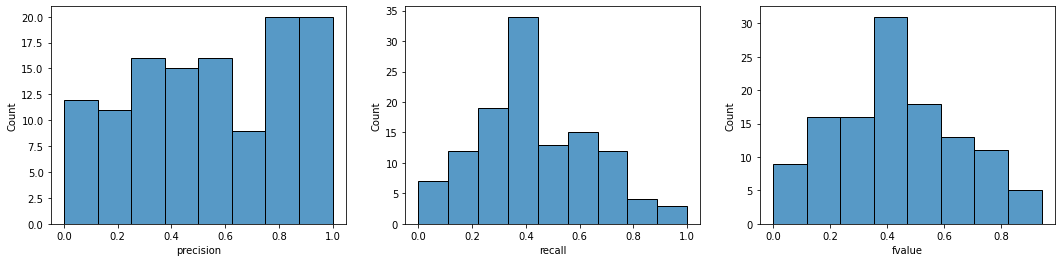

In [45]:
fig, axes = plt.subplots(1,3,figsize=(18,4))
sns.histplot(data=eval_df, x='precision', ax=axes[0])
sns.histplot(data=eval_df, x='recall', ax=axes[1])
sns.histplot(data=eval_df, x='fvalue', ax=axes[2]);

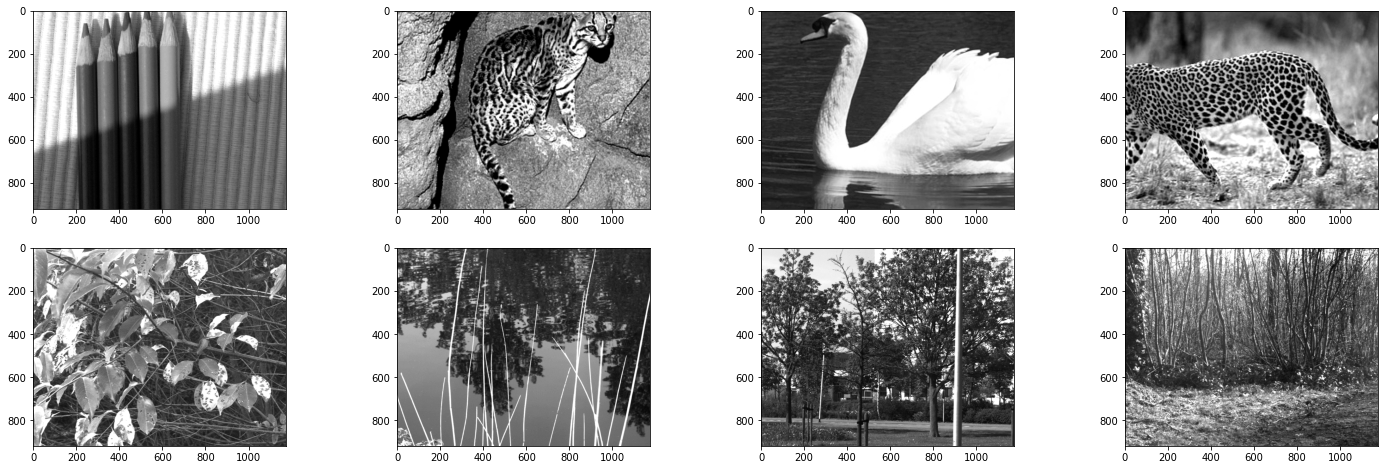

In [10]:
eval_df_sorted = eval_df.sort_values(by='fvalue', ascending=False)

fig, axes = plt.subplots(2, 4, figsize=(25, 8))
for i in range(4):
  best_image = cache.get_natural_scene_template(eval_df_sorted.iloc[i].name)
  axes[0, i].imshow(best_image, cmap=plt.cm.gray)

  worst_image = cache.get_natural_scene_template(eval_df_sorted.iloc[-(i+1)].name)
  axes[1, i].imshow(worst_image, cmap=plt.cm.gray)


plt.show()

Walker, E. Y., Sinz, F. H., Cobos, E., Muhammad, T., Froudarakis, E., Fahey, P. G., … Tolias, A. S. (2019). Inception loops discover what excites neurons most using deep predictive models. Nature Neuroscience, 22(12), 2060–2065. https://doi.org/10.1038/s41593-019-0517-x

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


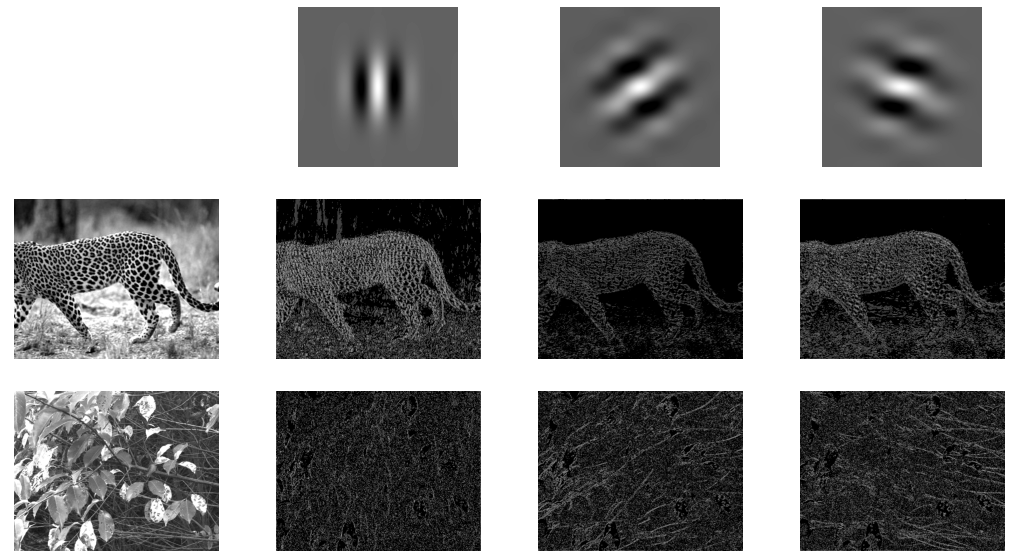

In [39]:
from scipy import ndimage as ndi
from skimage.filters import gabor_kernel
from skimage.util import img_as_float

def convolve(image, kernel):
  return ndi.convolve(image, kernel, mode='wrap')


fig, axes = plt.subplots(3, 4, figsize=(18, 10))
best_image = cache.get_natural_scene_template(eval_df_sorted.iloc[3].name)
axes[1, 0].imshow(best_image, cmap=plt.cm.gray)
worst_image = cache.get_natural_scene_template(eval_df_sorted.iloc[-1].name)
axes[2, 0].imshow(worst_image, cmap=plt.cm.gray)

for i, theta in enumerate([0, 45, 225]):
  kernel = gabor_kernel(0.4, theta=theta)
  axes[0, i+1].imshow(np.real(kernel), cmap=plt.cm.gray, interpolation='spline36')
  axes[1, i+1].imshow(convolve(best_image, kernel), cmap=plt.cm.gray)
  axes[2, i+1].imshow(convolve(worst_image, kernel), cmap=plt.cm.gray)

for ax in axes.flatten():
  ax.axis('off')

plt.show()